In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import harmonypy as hm
import anndata
import os
import sys
from matplotlib import pyplot as plt
sc.settings.set_figure_params(dpi=500, dpi_save=1000, figsize=(5,5), facecolor='white')


In [2]:
os.chdir('/home/groups/singlecell/smorabito/analysis/SERPENTINE/bin/BigSur/')
data_dir = '/home/groups/singlecell/smorabito/analysis/SERPENTINE/data/'
fig_dir = '/home/groups/singlecell/smorabito/analysis/SERPENTINE/figures/'


In [3]:
# load BigSur
bigsur_dir = "/home/groups/singlecell/smorabito/analysis/SERPENTINE/bin/BigSur/BigSur/"
sys.path.append(bigsur_dir)

from BigSur.feature_selection import mcfano_feature_selection as mcfano

In [4]:
# re-load the processed dataset 
adata = sc.read_h5ad('{}SERPENTINE_PCA_annotated_14-05-24.h5ad'.format(data_dir))
obs = adata.obs
del adata

In [5]:
# re-load the unprocessed data
adata_unp = sc.read('{}SERPENTINE_merged_unprocessed_090424.h5ad'.format(data_dir))

In [6]:
# add the obs table from the processed to the unprocessed
adata_unp = adata_unp[obs.index].copy()
adata_unp.obs = obs

### Testing bigsur feature selection on the myeloid cells

In [8]:
adata_unp.obs.general_annot.value_counts()

general_annot
T cells         123546
Tumor            62535
Myeloid          28437
Non-immune        7977
B cells           7816
LQ                7374
Plasma cells      4800
Name: count, dtype: int64

In [9]:
adata = adata_unp[adata_unp.obs.general_annot == 'Myeloid'].copy()

In [10]:
# remove lowly expressed genes:
sc.pp.filter_genes(adata, min_cells=3)

In [11]:
adata.shape

(28437, 28616)

In [12]:
adata.layers['counts'] = adata.X.copy()

In [13]:
# normalize
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# retain the "Raw" adata object for later
# adata.raw = adata

In [14]:
mcfano(adata, layer='counts', n_jobs=1) # Replace sc.pp.highly_variable_genes(adata) call


Using 0.05 for pvalue cutoff and 0.96 for mcfano quantile cutoff for highly variable genes.


In [17]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

In [18]:
sc.external.pp.harmony_integrate(adata, key = ['Subproject_CNAG_x'])

2024-05-17 11:16:15,125 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-17 11:16:18,554 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-17 11:16:18,760 - harmonypy - INFO - Iteration 1 of 10
2024-05-17 11:16:26,073 - harmonypy - INFO - Iteration 2 of 10
2024-05-17 11:16:33,408 - harmonypy - INFO - Iteration 3 of 10
2024-05-17 11:16:40,676 - harmonypy - INFO - Iteration 4 of 10
2024-05-17 11:16:47,943 - harmonypy - INFO - Iteration 5 of 10
2024-05-17 11:16:53,286 - harmonypy - INFO - Iteration 6 of 10
2024-05-17 11:16:57,979 - harmonypy - INFO - Iteration 7 of 10
2024-05-17 11:17:01,713 - harmonypy - INFO - Iteration 8 of 10
2024-05-17 11:17:06,758 - harmonypy - INFO - Iteration 9 of 10
2024-05-17 11:17:09,864 - harmonypy - INFO - Converged after 9 iterations


In [20]:
sc.pp.neighbors(adata, use_rep = 'X_pca_harmony', n_neighbors=20, n_pcs=30, metric='cosine')

/home/groups/singlecell/smorabito/.conda/envs/serp-scanpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
sc.tl.umap(adata, min_dist=0.35, method='umap')

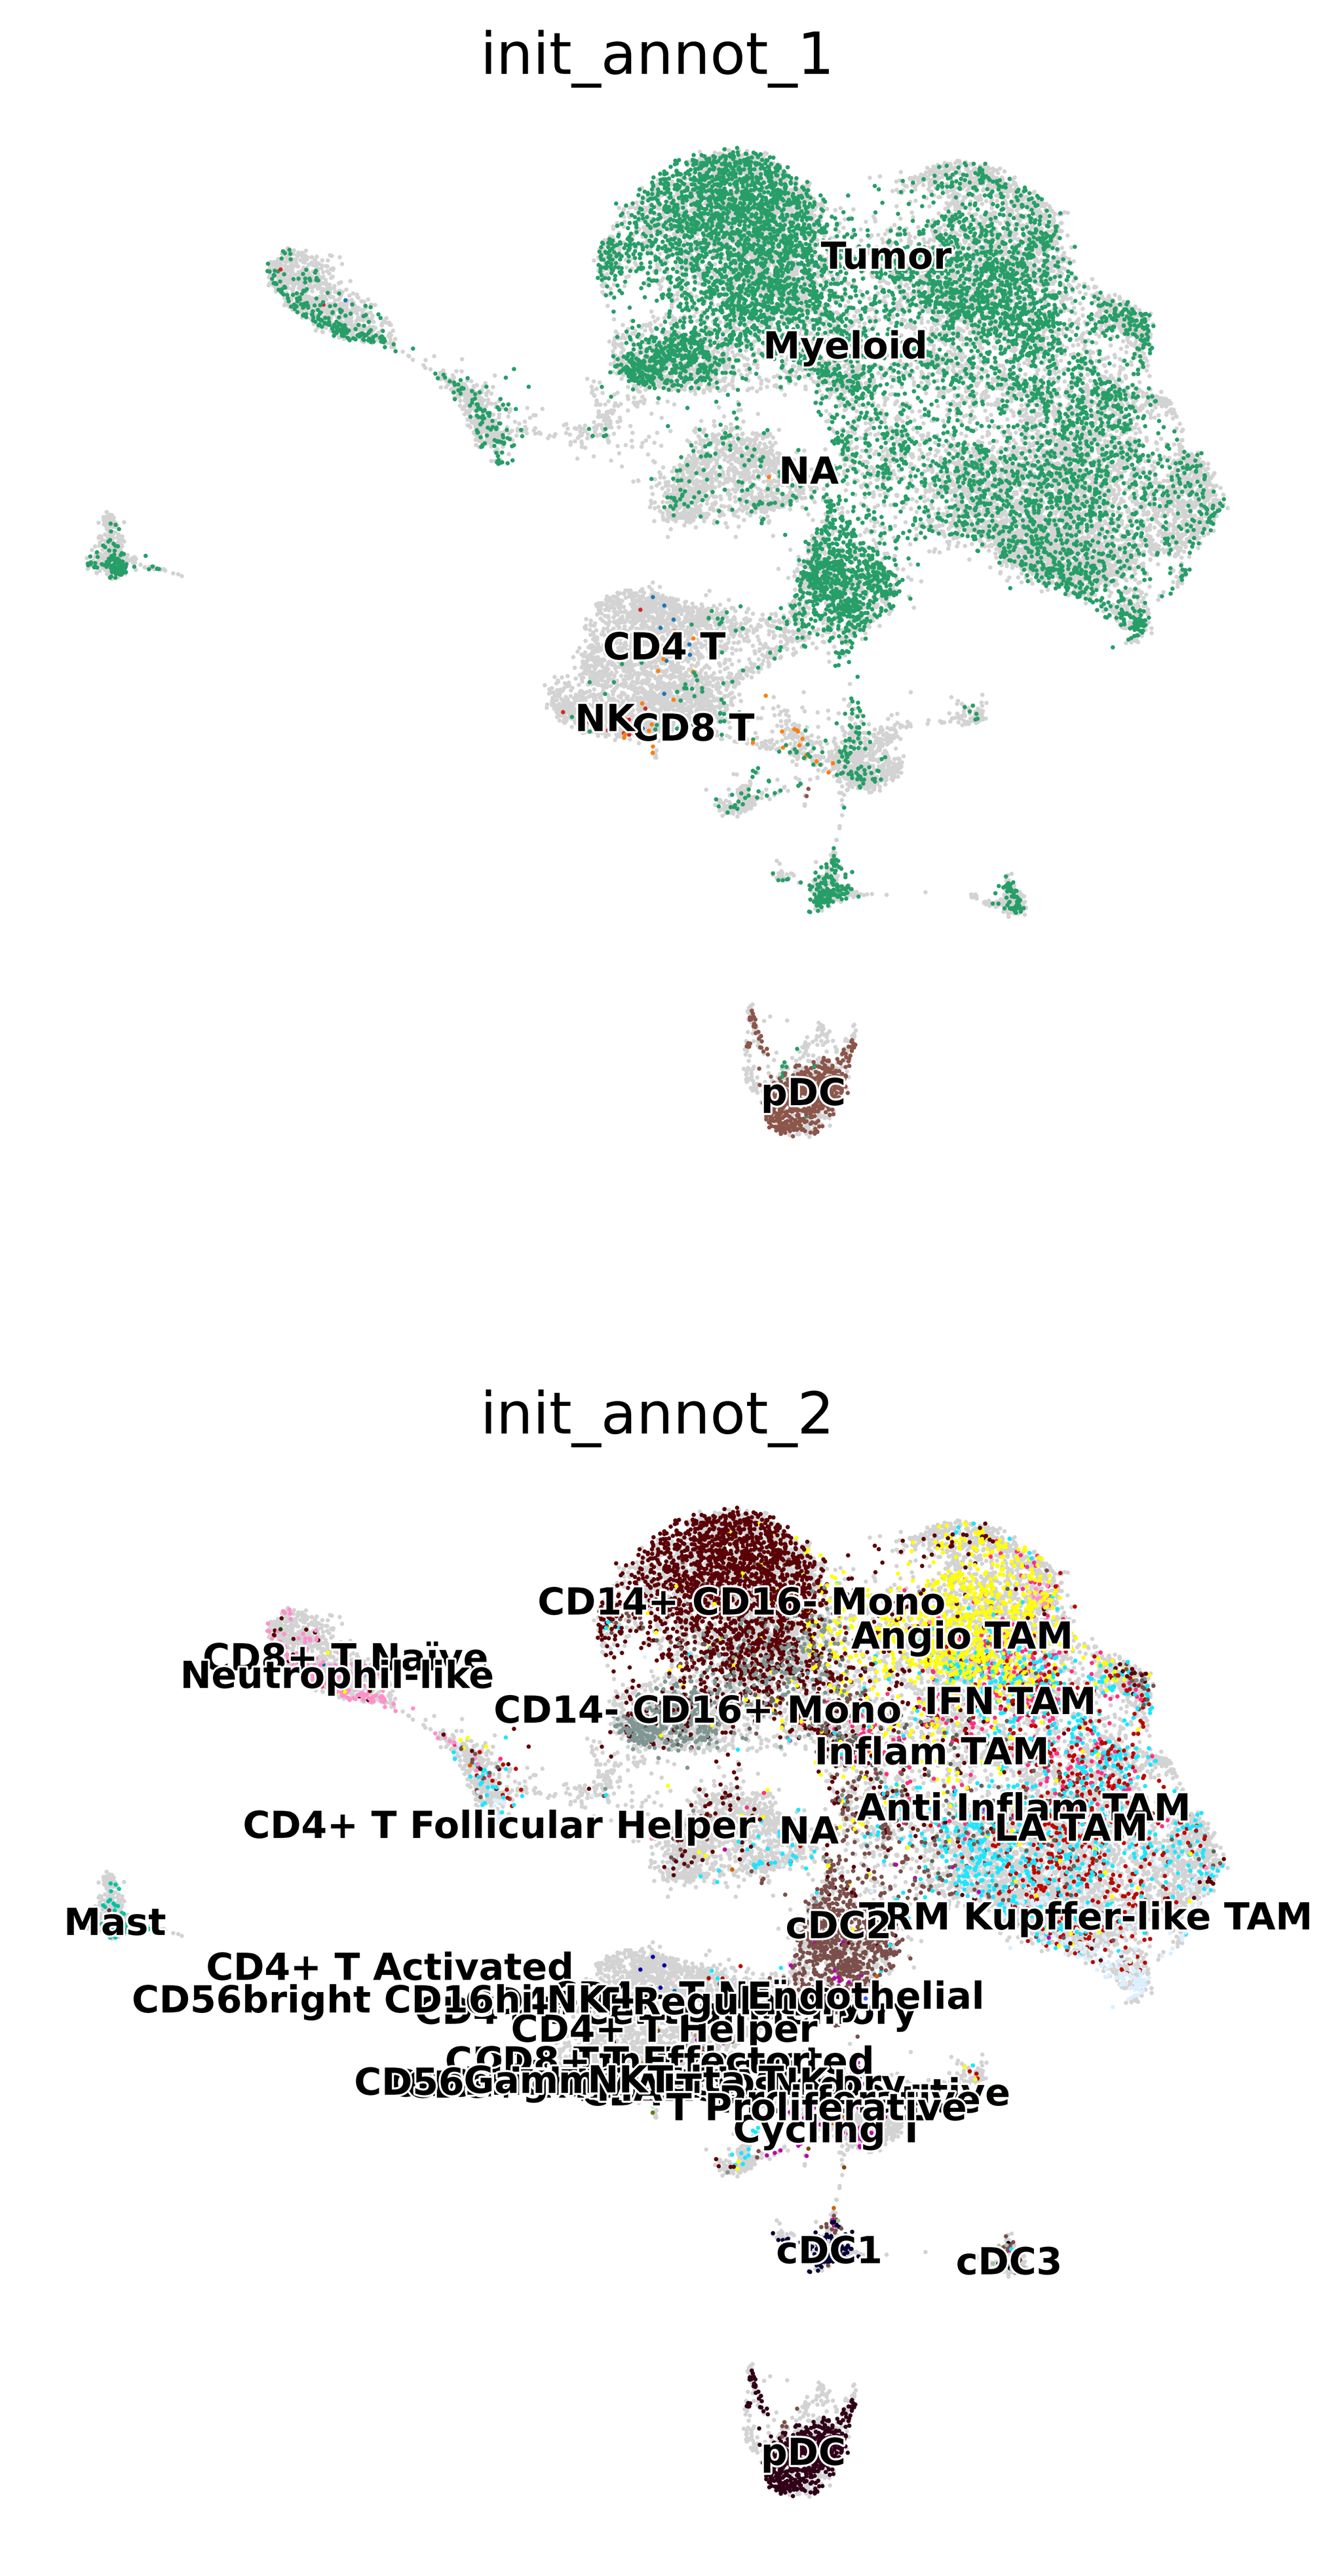

In [22]:
sc.settings.set_figure_params(dpi=400, dpi_save=500, figsize=(5,5), facecolor='white')
sc.pl.umap(
    adata, 
    color=['init_annot_1', 'init_annot_2'],
    frameon=False, 
    legend_loc='on data', 
    legend_fontoutline=1, 
    legend_fontsize=9, 
    ncols=1,
    save='_initial_annotation_myeloid.pdf'
)

### Default feature selection

In [23]:
adata = adata_unp[adata_unp.obs.general_annot == 'Myeloid'].copy()

In [24]:
# remove lowly expressed genes:
sc.pp.filter_genes(adata, min_cells=3)

# normalize
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# retain the "Raw" adata object for later
# adata.raw = adata

In [25]:
# identify HVGs
sc.pp.highly_variable_genes(
    adata
)

In [26]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

In [27]:
sc.external.pp.harmony_integrate(adata, key = ['Subproject_CNAG_x'])

2024-05-17 11:32:23,404 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-17 11:32:26,729 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-17 11:32:26,939 - harmonypy - INFO - Iteration 1 of 10
2024-05-17 11:32:34,451 - harmonypy - INFO - Iteration 2 of 10
2024-05-17 11:32:42,126 - harmonypy - INFO - Iteration 3 of 10
2024-05-17 11:32:49,682 - harmonypy - INFO - Iteration 4 of 10
2024-05-17 11:32:56,504 - harmonypy - INFO - Iteration 5 of 10
2024-05-17 11:33:00,303 - harmonypy - INFO - Converged after 5 iterations


In [28]:
sc.pp.neighbors(adata, use_rep = 'X_pca_harmony', n_neighbors=20, n_pcs=30, metric='cosine')

In [29]:
sc.tl.umap(adata, min_dist=0.35, method='umap')

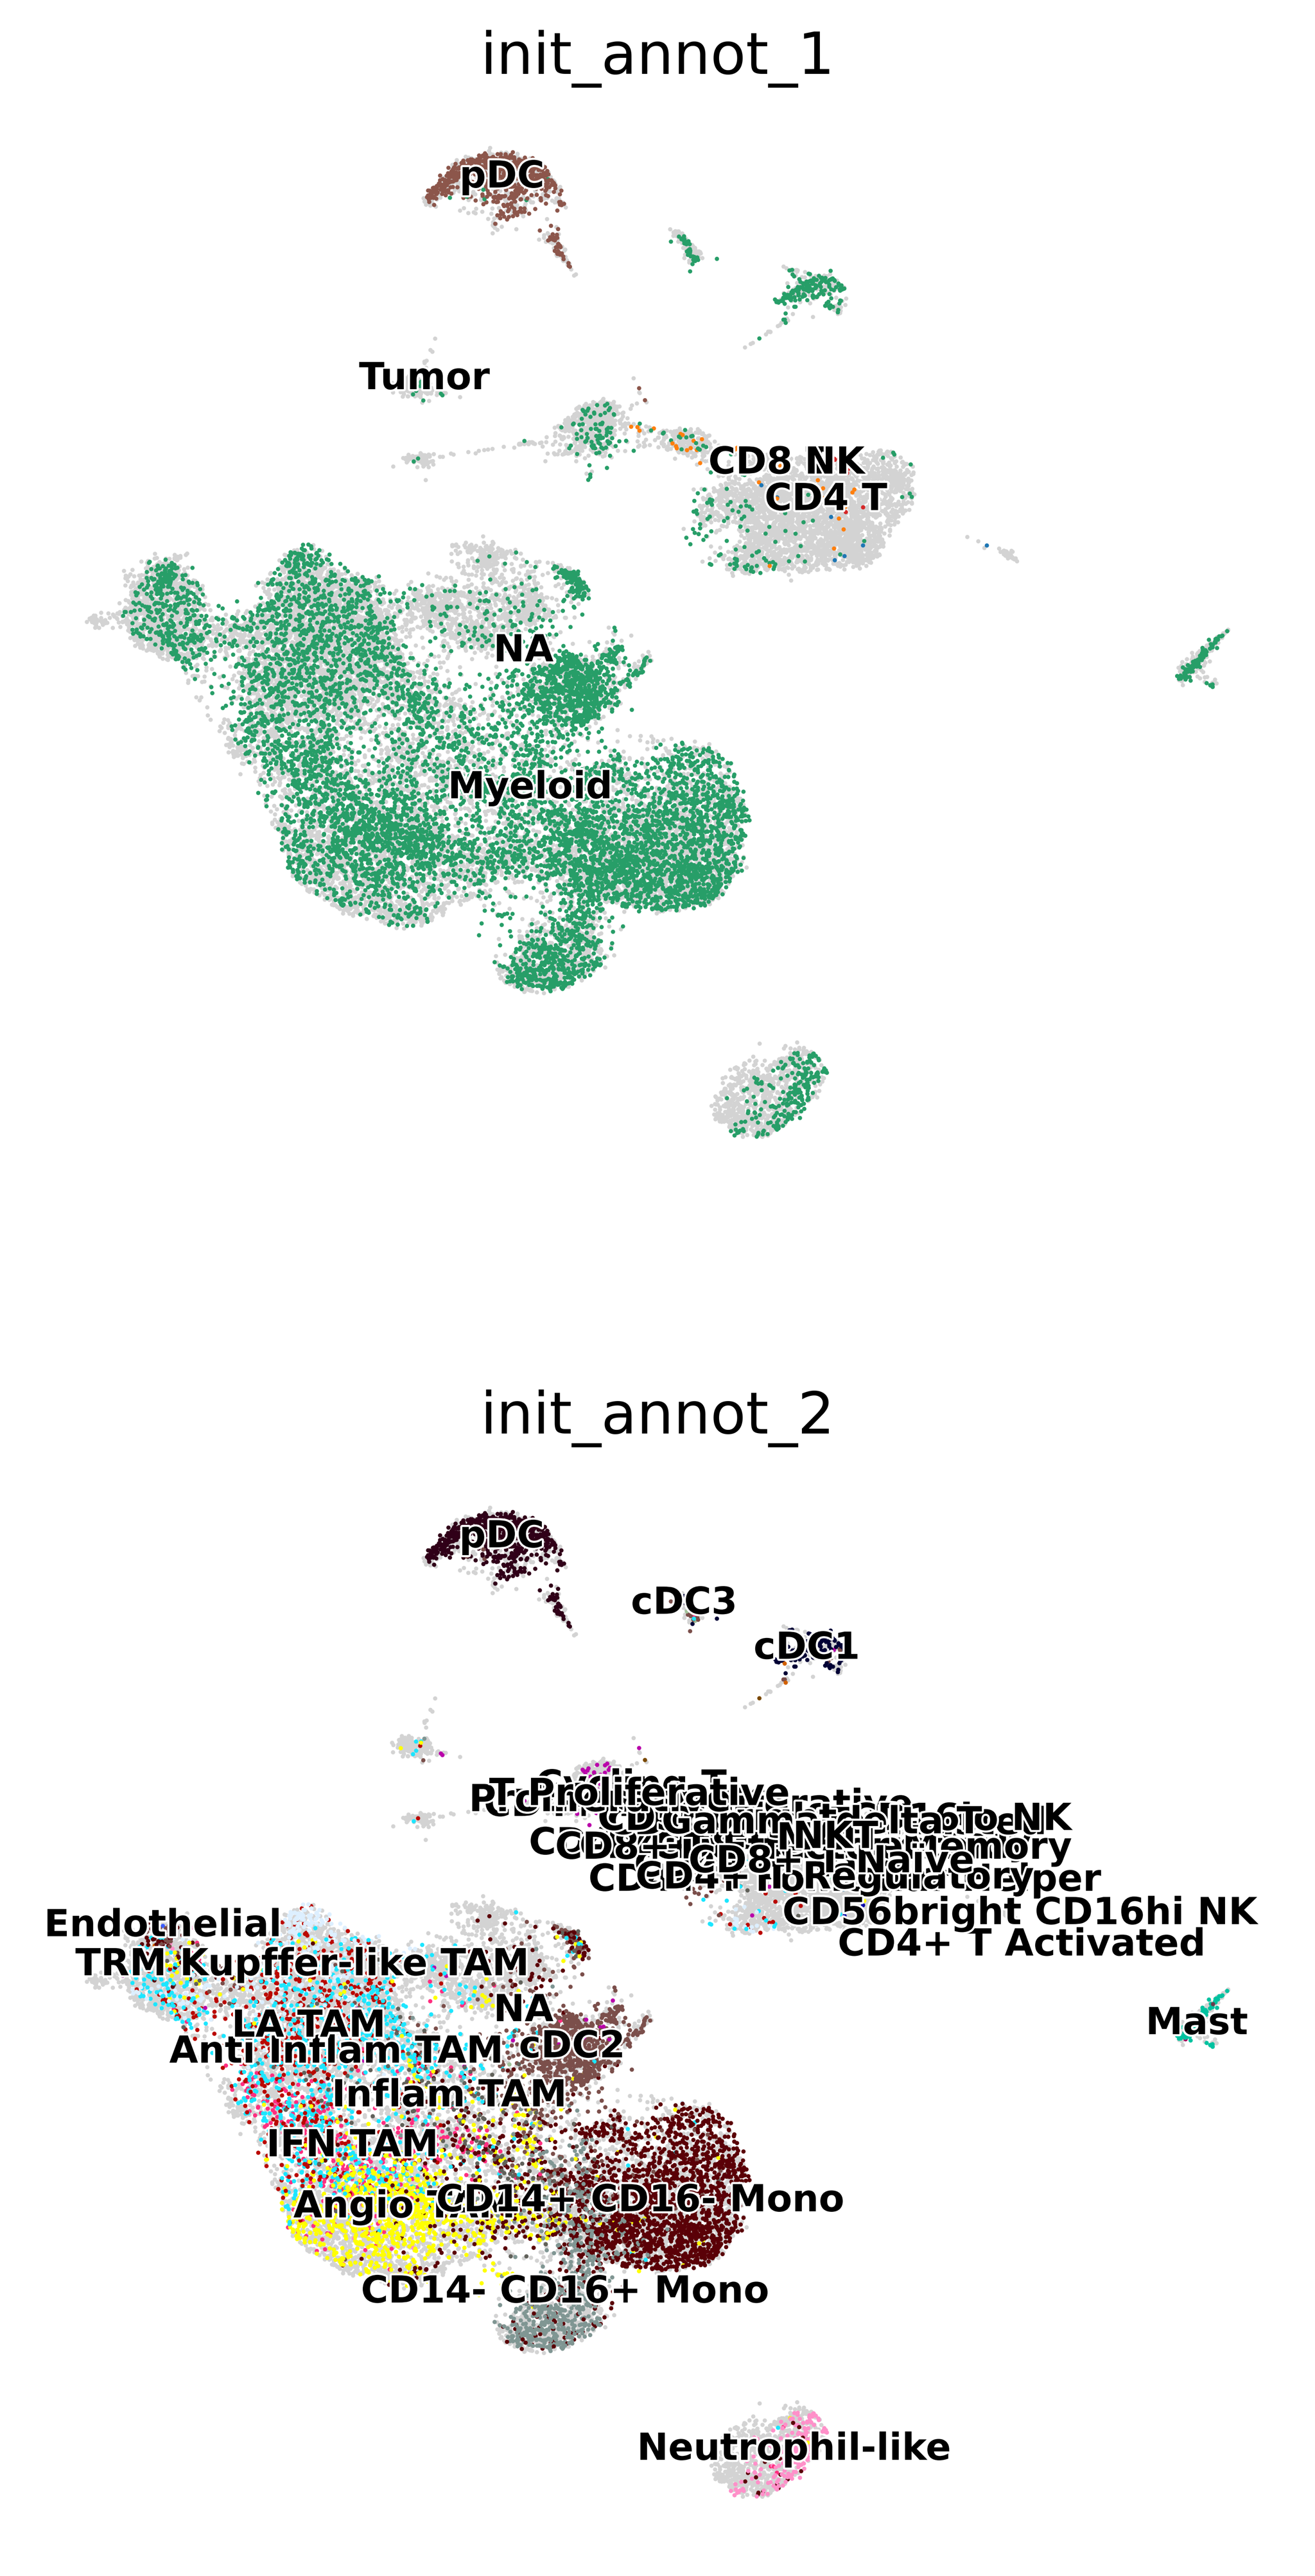

In [30]:
sc.settings.set_figure_params(dpi=400, dpi_save=500, figsize=(5,5), facecolor='white')
sc.pl.umap(
    adata, 
    color=['init_annot_1', 'init_annot_2'],
    frameon=False, 
    legend_loc='on data', 
    legend_fontoutline=1, 
    legend_fontsize=9, 
    ncols=1,
    save='_initial_annotation_myeloid_default.pdf'
)

In [37]:
sc.tl.leiden(adata, resolution=1.5)


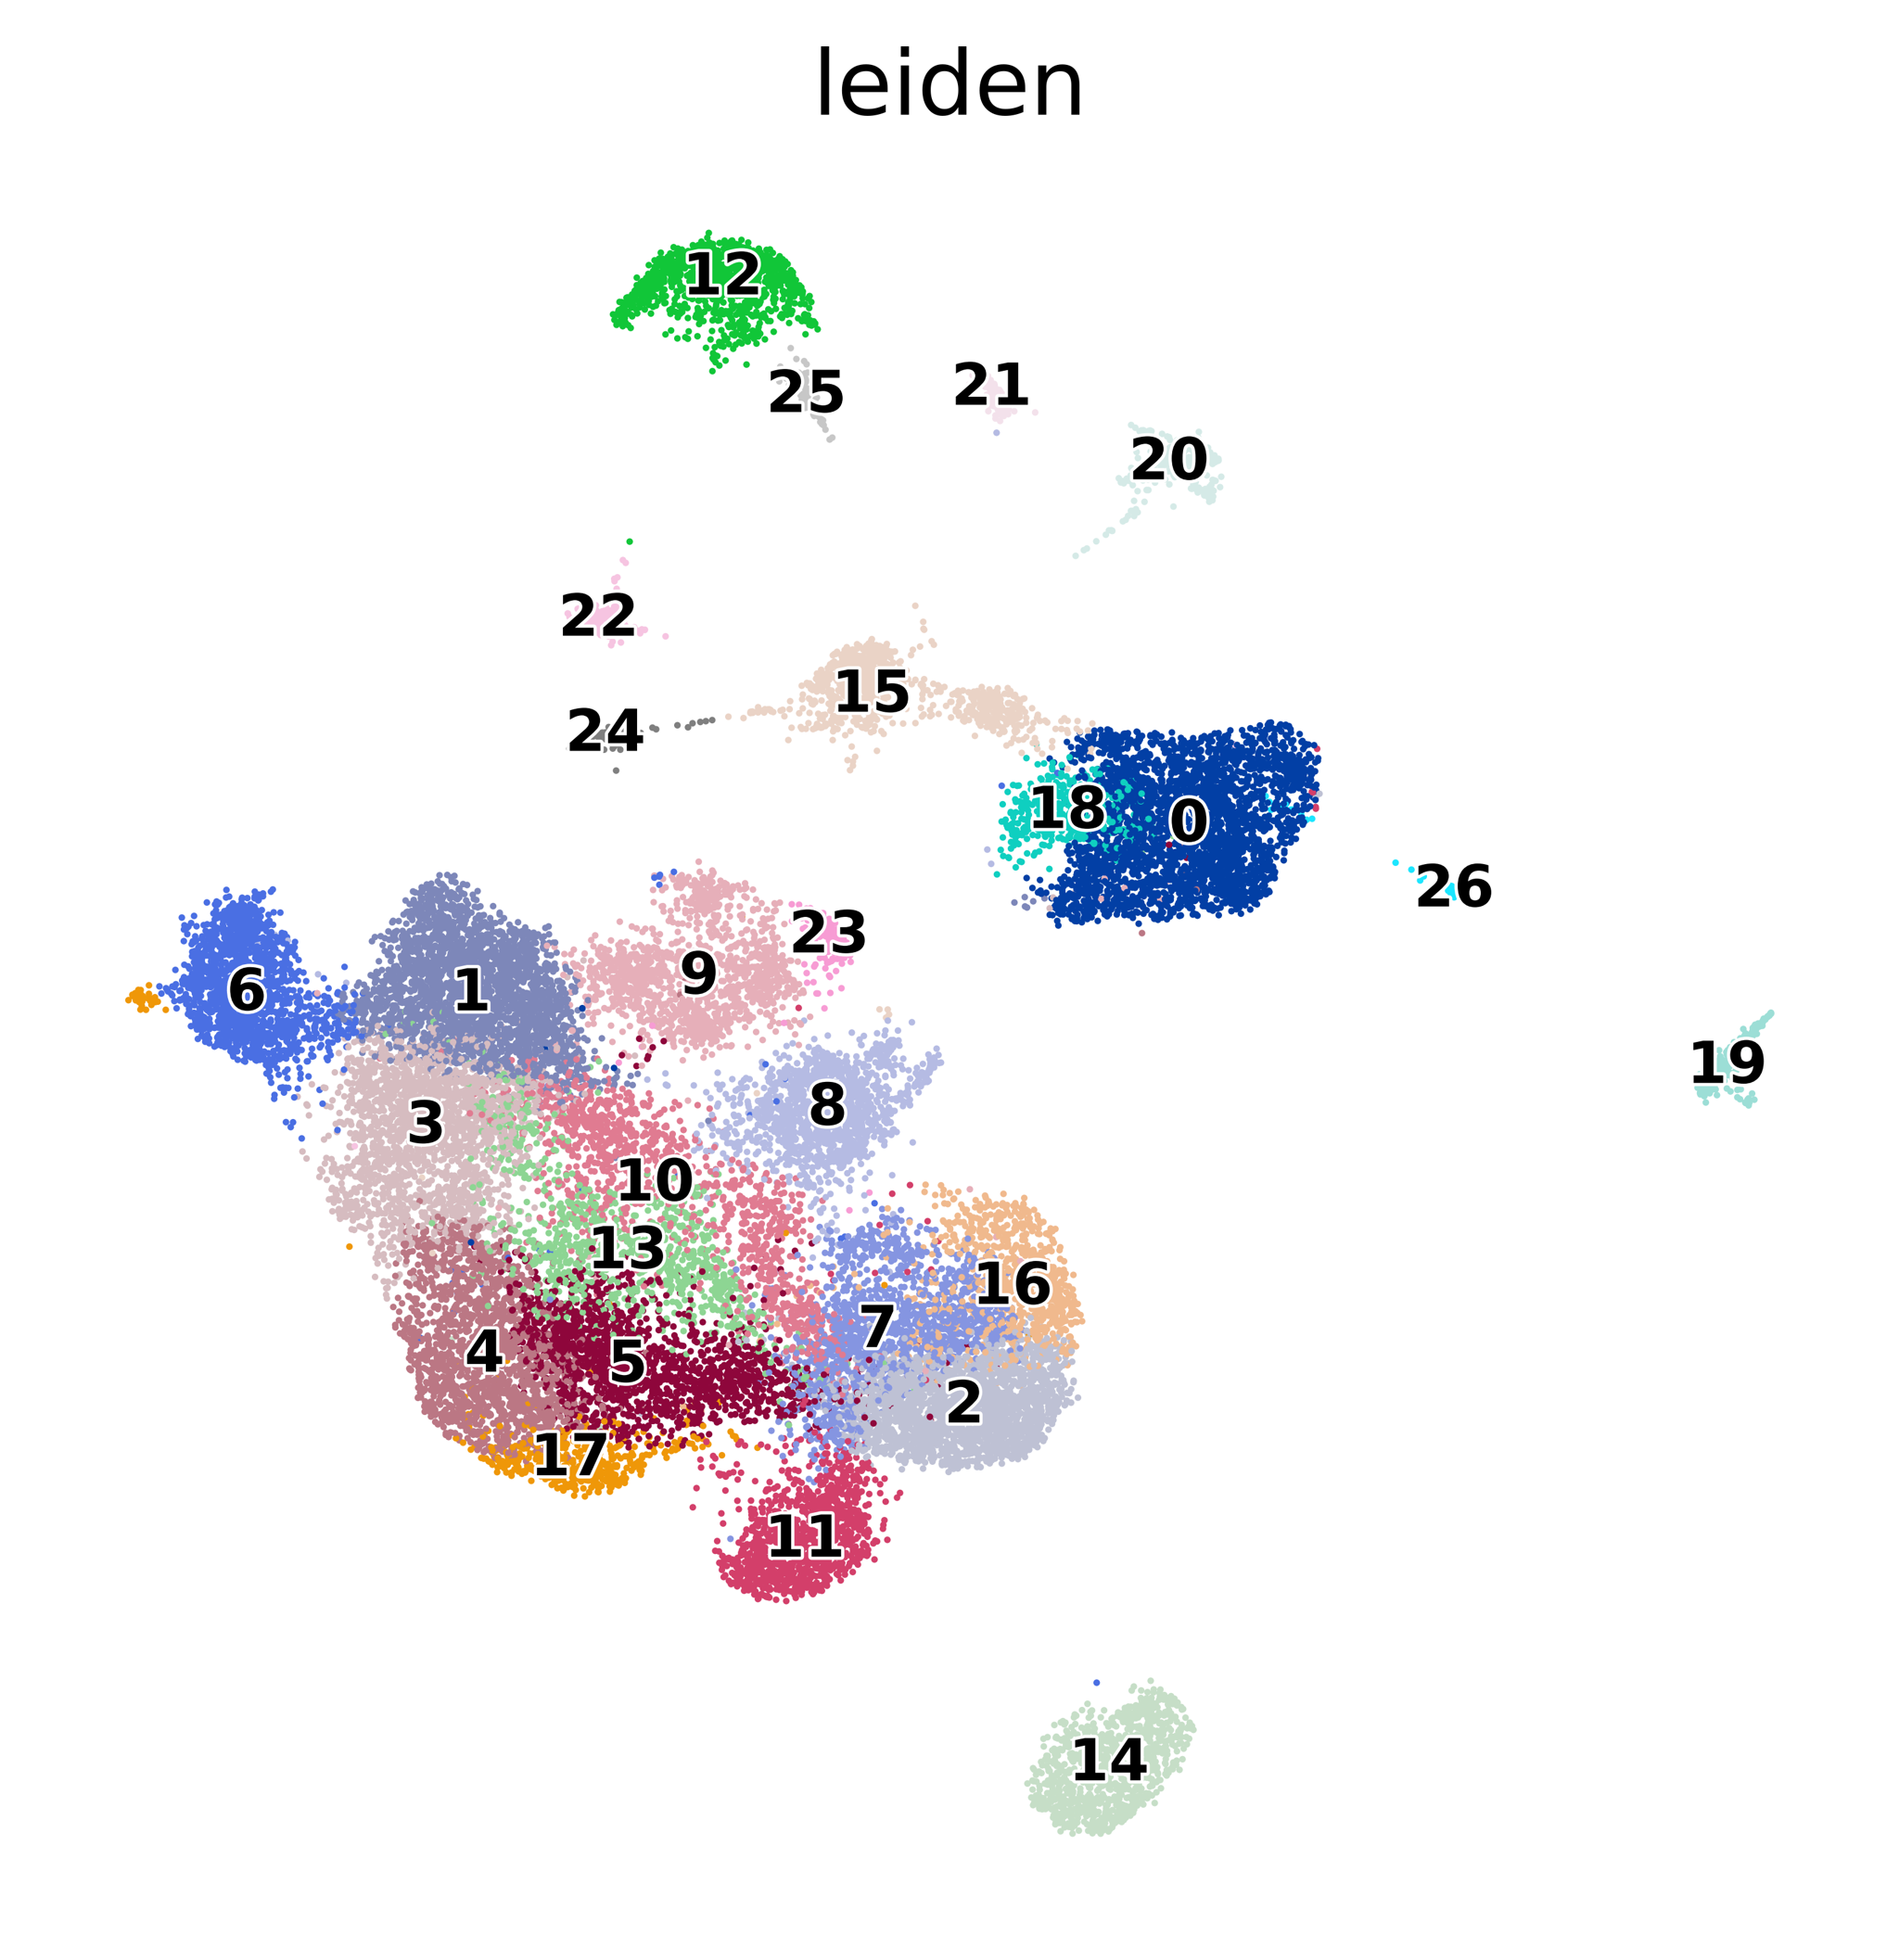

In [38]:
sc.settings.set_figure_params(dpi=400, dpi_save=500, figsize=(5,5), facecolor='white')
sc.pl.umap(
    adata, 
    color=['leiden'],
    frameon=False, 
    legend_loc='on data', 
    legend_fontoutline=1, 
    legend_fontsize=9, 
    ncols=1,
    save='_leiden_myeloid.pdf'
)

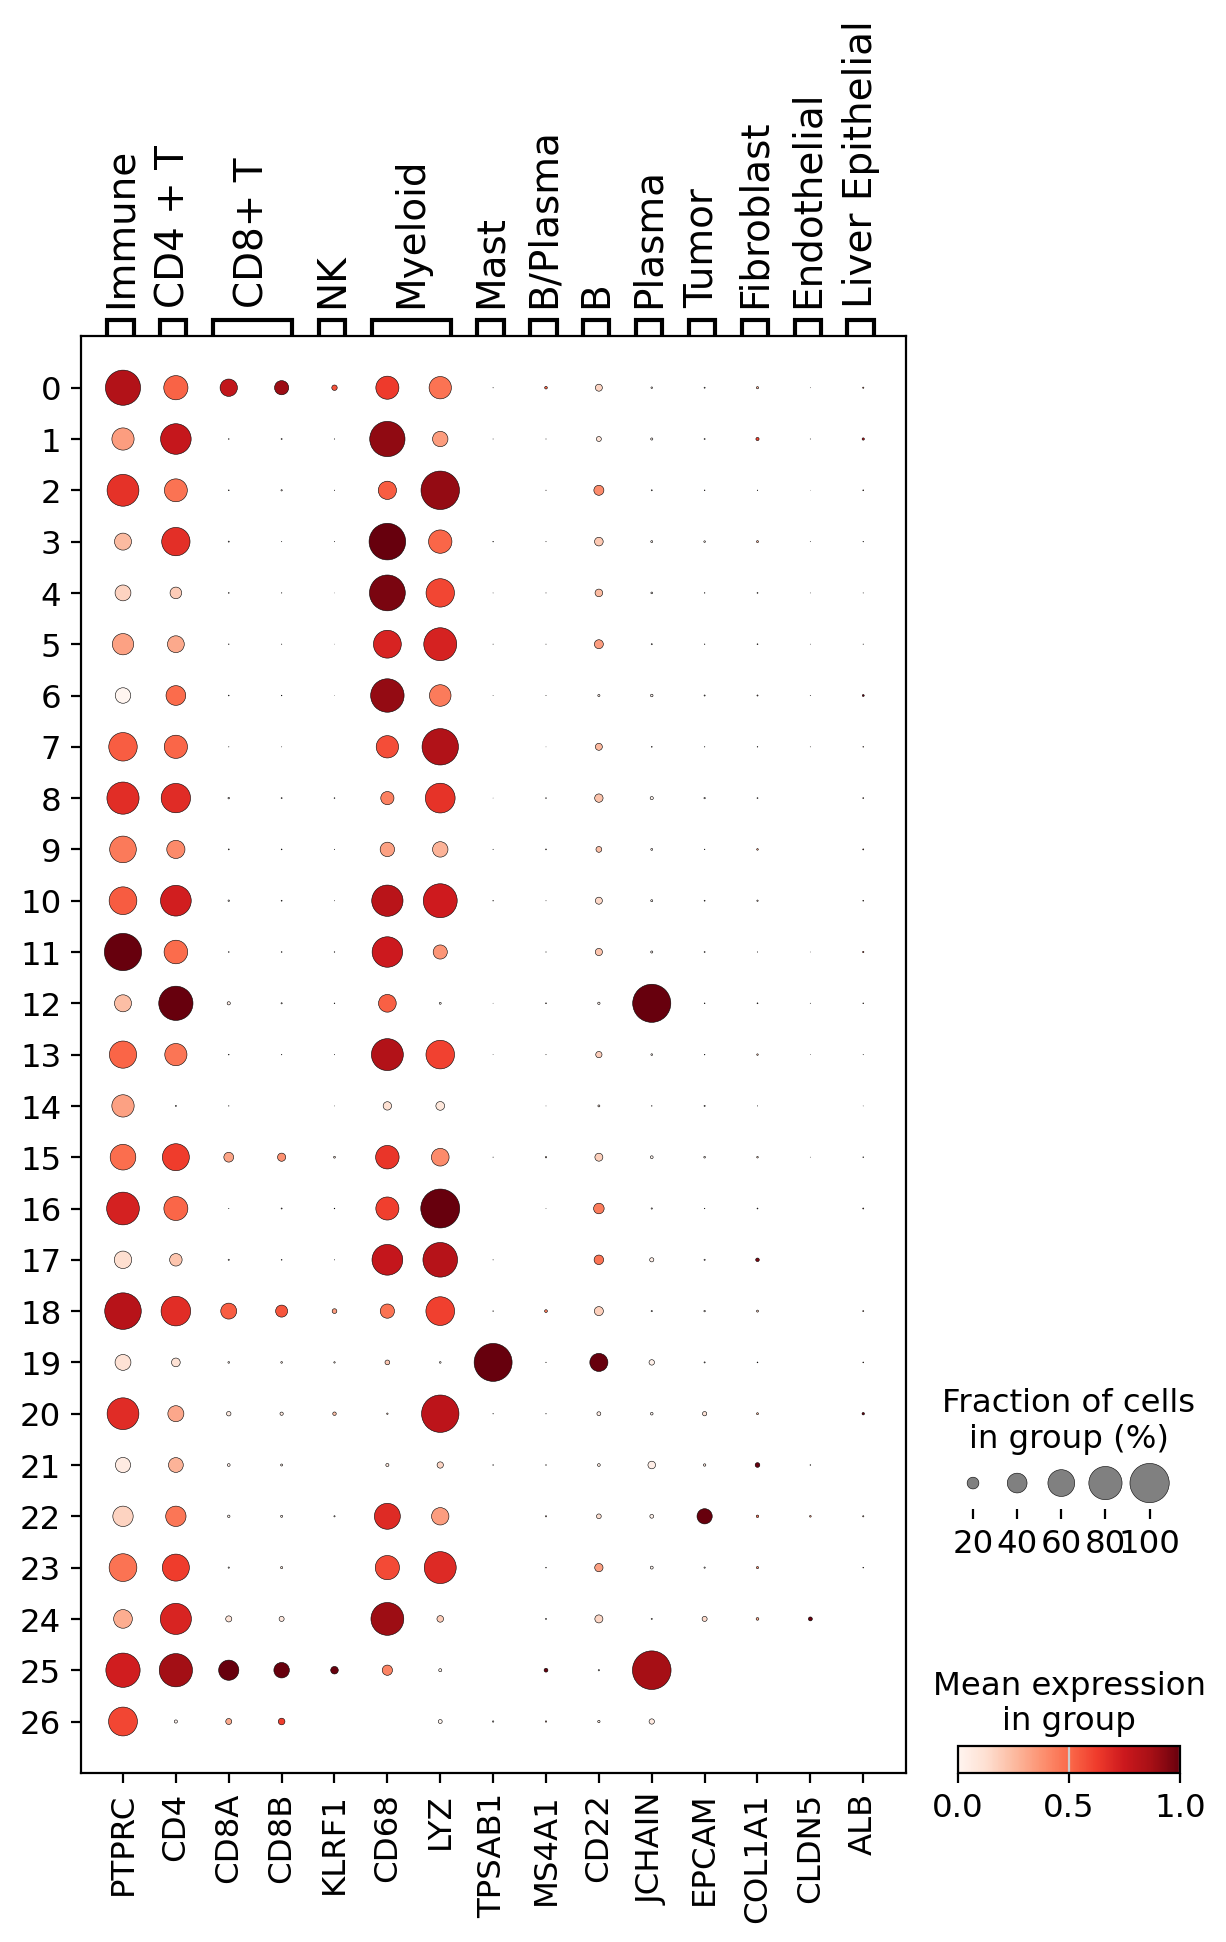

In [39]:

sc.settings.set_figure_params(dpi=100, dpi_save=300, figsize=(15,5), facecolor='white')

marker_dict = {
    'Immune': ['PTPRC'],
    'CD4 + T': ['CD4'],
    'CD8+ T': ['CD8A', 'CD8B'],
    'NK': ['KLRF1'],
    'Myeloid': ['CD68', 'LYZ'],
    'Mast': ['TPSAB1'],
    'B/Plasma': ['MS4A1'],
    'B': ['CD22'],
    'Plasma': ['JCHAIN'],
    'Tumor': ['EPCAM'],
    'Fibroblast': ['COL1A1'],
    'Endothelial': ['CLDN5'],
    'Liver Epithelial': ['ALB']
}


sc.pl.dotplot(
    adata, marker_dict, 'leiden',
    #dendrogram=True,
    standard_scale='var', swap_axes=False
)

#sc.pl.dotplot(adata, marker_dict, groupby='leiden', figsize=(12,6), standard_scale='var',  dendrogram=True, save='markers.pdf')

In [33]:
adata.obs.doublet_score

barcode
AAACCTGGTCAAAGAT-1-0     0.106870
AAATGCCTCATCATTC-1-0     0.164948
AACCATGCATCACAAC-1-0     0.096774
AACTCAGCAAGCCTAT-1-0     0.055118
AACTCCCCACATTTCT-1-0     0.079872
                           ...   
TTTCCTCAGCACCGCT-1-38    0.075099
TTTCCTCCAAACTGCT-1-38    0.194030
TTTGCGCCATATGGTC-1-38    0.241685
TTTGGTTGTCGATTGT-1-38    0.153605
TTTGTCATCATCTGCC-1-38    0.211155
Name: doublet_score, Length: 28437, dtype: float64

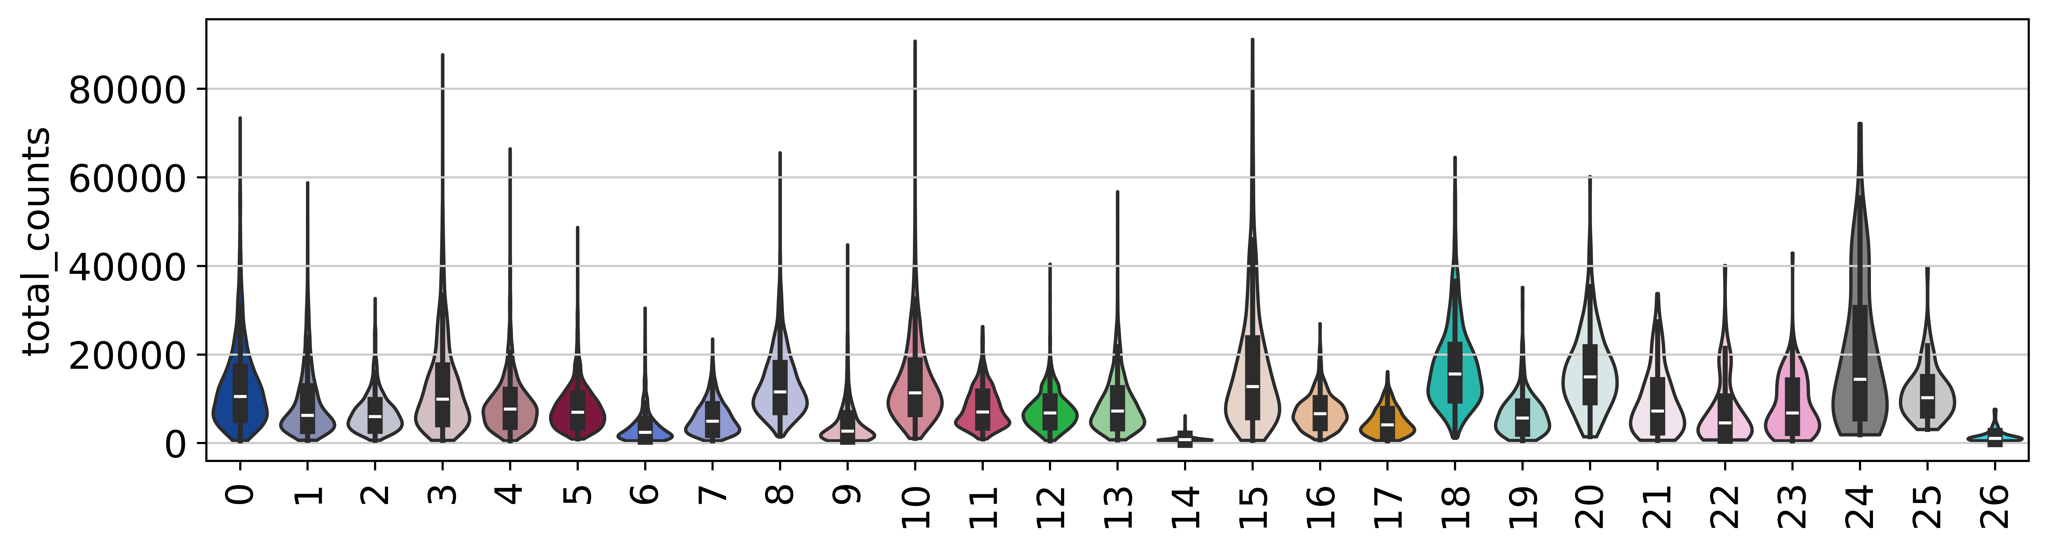

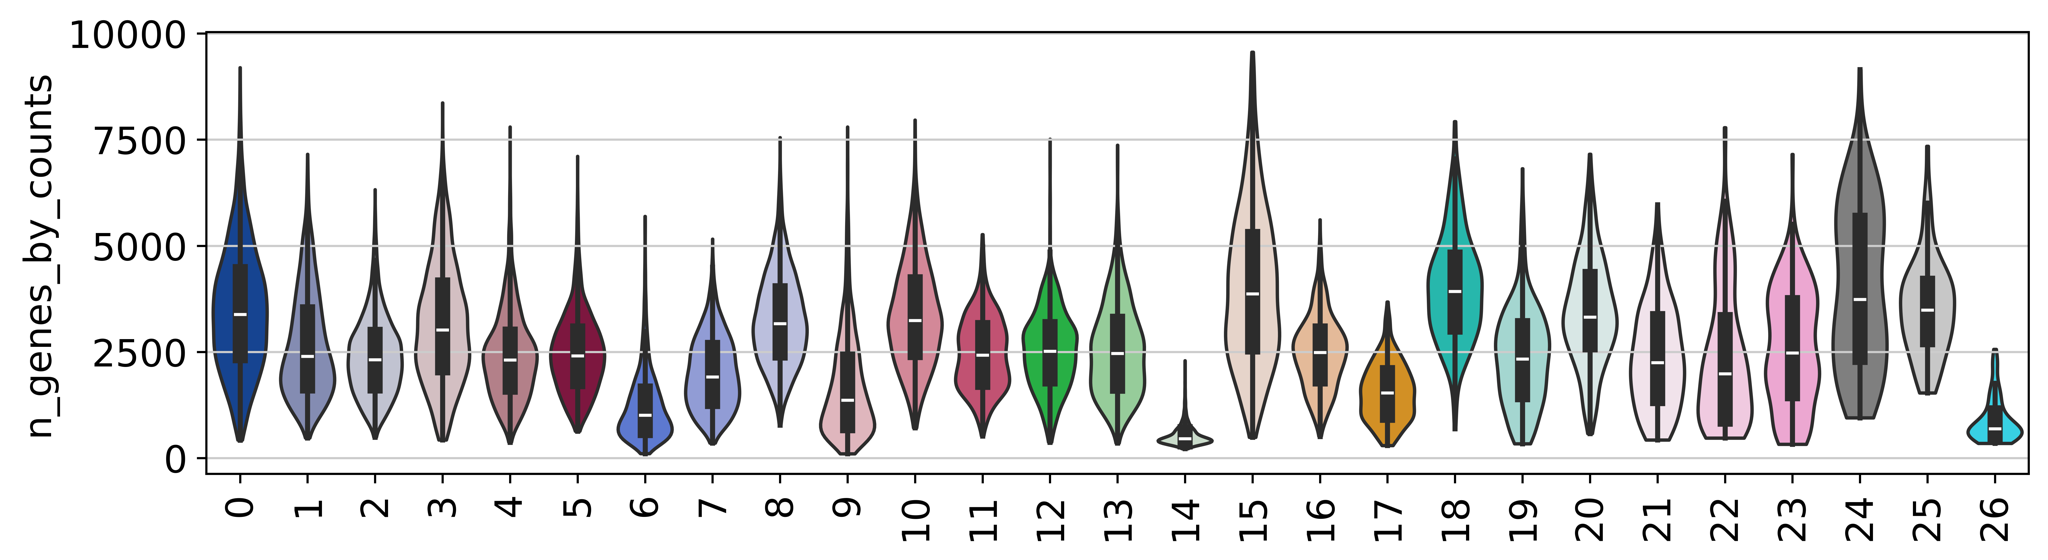

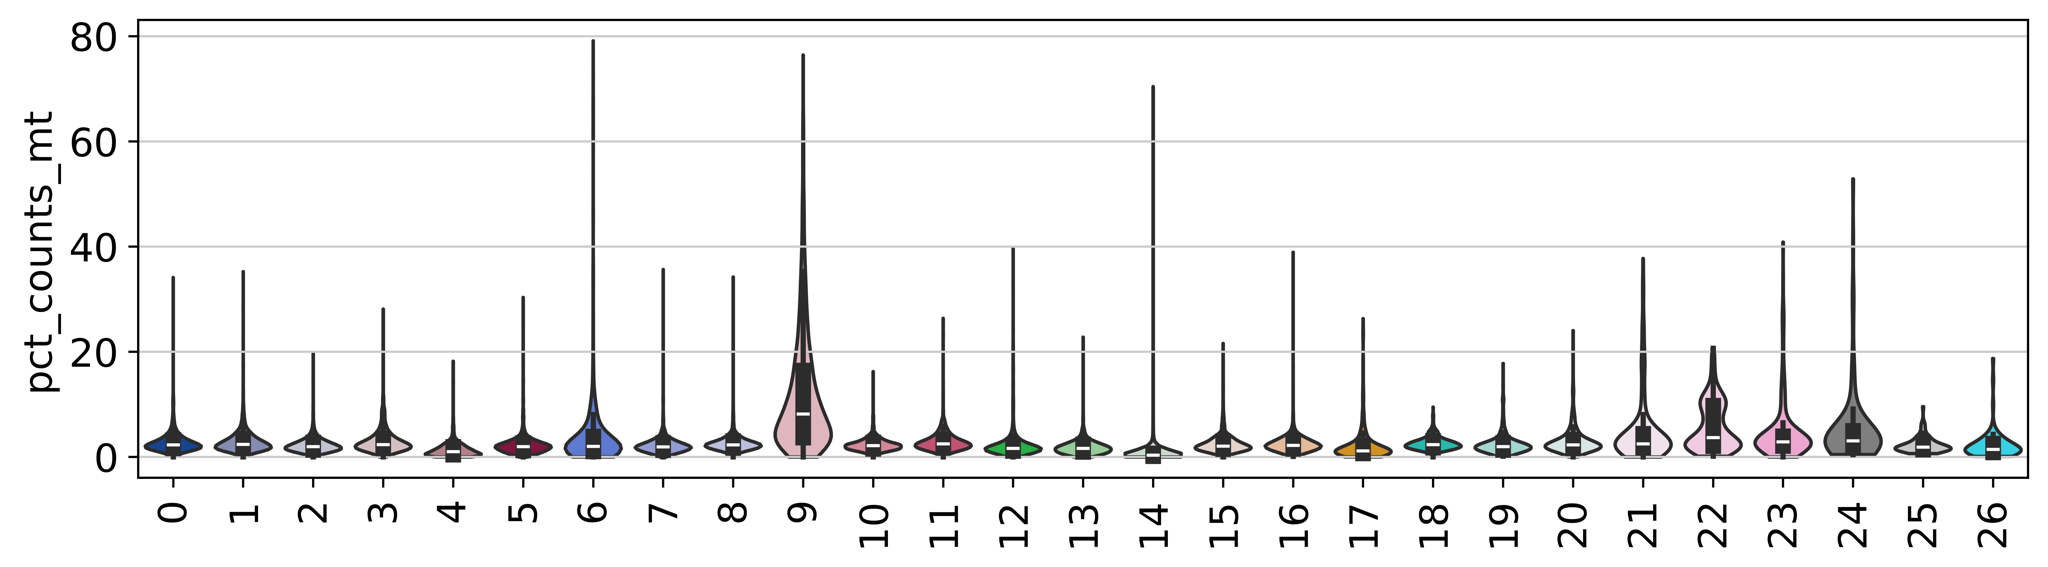

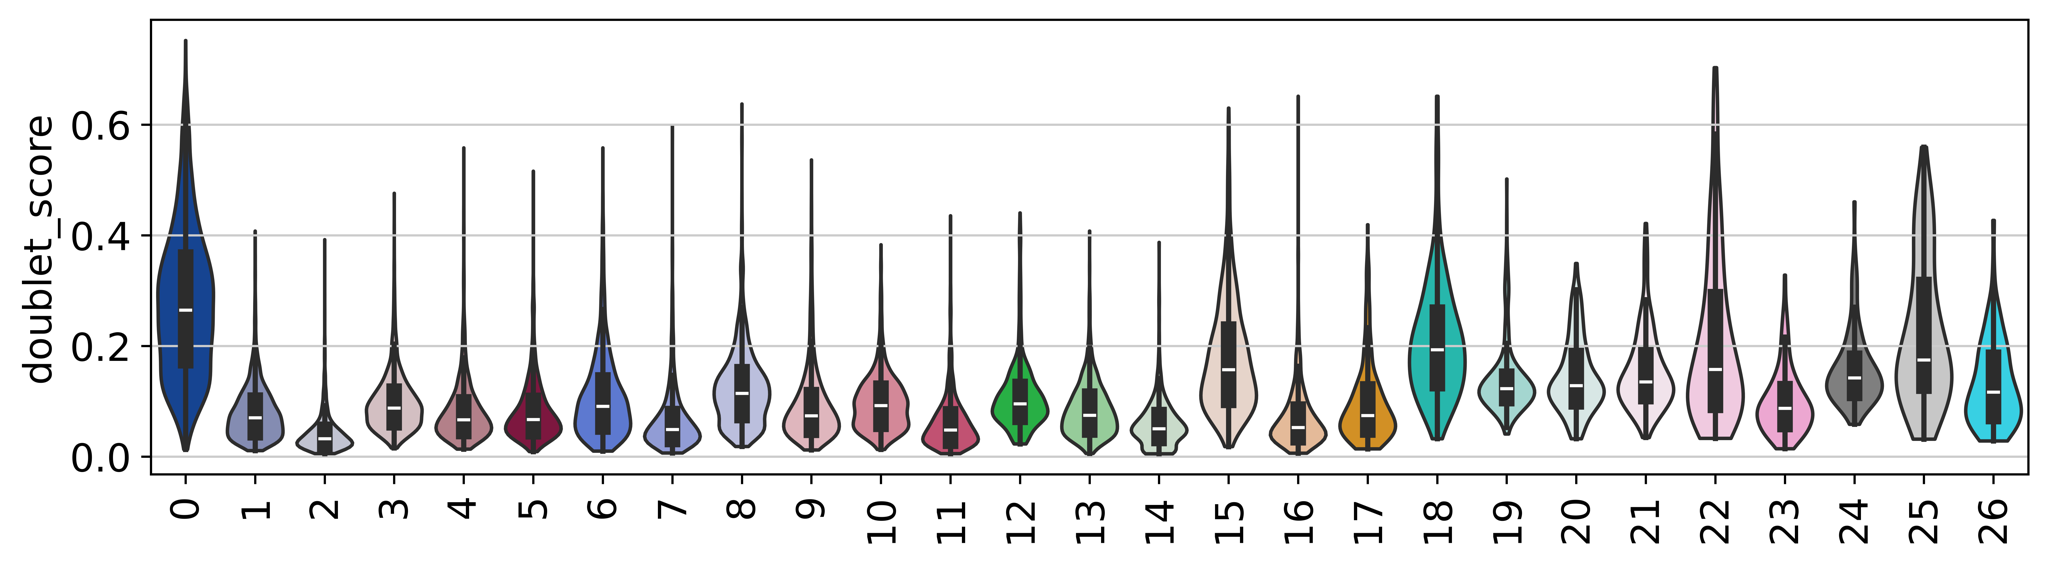

In [40]:
sc.settings.set_figure_params(dpi=400, dpi_save=400, figsize=(10,3), facecolor='white')
sc.pl.violin(adata,[ 'total_counts'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'n_genes_by_counts'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'pct_counts_mt'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'doublet_score'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=90)